# Introduction to Machine Learning
## Project Phase 2

Sina Fathi | 402111261

Seyyed Amirmahdi Sadrzadeh | 401102015

### Part 1: Data Preproccessing

First we import the needed libraries:

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import random
from sympy import mod_inverse

Now we use torch library to load the MNIST dataset and then turn them to numpy arrays:

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

# getting the train data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)

X_train_torch = trainset.data
Y_train_torch = trainset.targets

X_train = X_train_torch.numpy()
Y_train = Y_train_torch.numpy()

In [5]:
# getting the test data
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

X_test_torch = testset.data
Y_test_torch = testset.targets

X_test = X_test_torch.numpy()
Y_test = Y_test_torch.numpy()

To use the datas, we binarize them by setting a threshold equal to 128. So all pixels with values higher than 128 will be set to 1 and others will be set to 0. We also flatten the datas to use them in our model:

In [6]:
threshold = 128

X_test = (X_test > threshold).astype(np.uint32)
X_test_binary = X_test.reshape(-1, 28 * 28)

X_train = (X_train > threshold).astype(np.uint32)
X_train_binary = X_train.reshape(-1, 28 * 28)

The plot to show the samples:

In [7]:
def show_samples(samples, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].reshape(28, 28), cmap='binary')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

And now we use the above function to show 10 samples from the dataset:

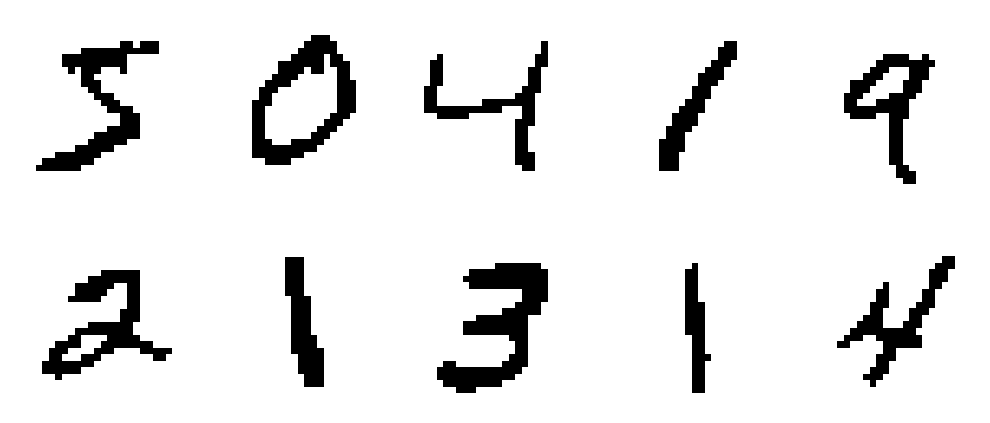

In [8]:
show_samples(X_train_binary[:10])

# Simple Boltzman machine:

In [14]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.W = np.random.normal(0, 0.1, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def gibbs_sampling(self, hid, k):
        v_prob_0 = self.sigmoid(np.dot(hid, self.W.T) + self.v_bias)
        v = self.sample(v_prob_0)
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v = self.sample(v_prob)
        return v

    def contrastive_divergence(self, v, k):
        h_prob_0 = self.sigmoid(np.dot(v, self.W) + self.h_bias)
        h_sample_0 = self.sample(h_prob_0)

        v_neg = v.copy()

        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob_neg = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v_neg = self.sample(v_prob_neg)

        h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)

        positive_grad = np.dot(v.T, h_prob_0)
        negative_grad = np.dot(v_neg.T, h_prob_neg)

        batch_size = v.shape[0]
        self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
        self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
        self.h_bias += self.learning_rate * np.mean(h_prob_0 - h_prob_neg, axis=0)

        return v_neg

    def train(self, data, epochs=10, k=1, batch_size=64):
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for batch_start in range(0, len(data), batch_size):
                batch = data[batch_start:batch_start + batch_size]
                v_neg = self.contrastive_divergence(batch, k)
                epoch_loss += np.mean((batch - v_neg) ** 2)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data):.5f}")

    def generate_samples(self, n_samples=10, k=1):
        samples = []
        for i in range(n_samples):
            sample = np.random.binomial(1, 0.5, self.n_hidden)
            sample = self.gibbs_sampling(sample, k)
            samples.append(sample)
        return np.array(samples)

In [17]:
n_visible = X_train_binary.shape[1]
n_hidden = 32
k_values = [1, 5, 10]

Training the normal model:

In [13]:
# آموزش ماشین بولتزمن ساده
rbms = {}
for k in k_values:
    print(f"Training RBM with k={k}")
    rbm = RBM(n_visible, n_hidden)
    rbm.train(X_train_binary, epochs=10, k=k)
    rbms[k] = rbm

Training RBM with k=1
Epoch 1/10, Loss: 0.00199
Epoch 2/10, Loss: 0.00160
Epoch 3/10, Loss: 0.00152
Epoch 4/10, Loss: 0.00148
Epoch 5/10, Loss: 0.00146
Epoch 6/10, Loss: 0.00145
Epoch 7/10, Loss: 0.00145
Epoch 8/10, Loss: 0.00144
Epoch 9/10, Loss: 0.00144
Epoch 10/10, Loss: 0.00143
Training RBM with k=5
Epoch 1/10, Loss: 0.00220
Epoch 2/10, Loss: 0.00173
Epoch 3/10, Loss: 0.00164
Epoch 4/10, Loss: 0.00158
Epoch 5/10, Loss: 0.00155
Epoch 6/10, Loss: 0.00153
Epoch 7/10, Loss: 0.00152
Epoch 8/10, Loss: 0.00151
Epoch 9/10, Loss: 0.00150
Epoch 10/10, Loss: 0.00149
Training RBM with k=10
Epoch 1/10, Loss: 0.00230
Epoch 2/10, Loss: 0.00181
Epoch 3/10, Loss: 0.00171
Epoch 4/10, Loss: 0.00165
Epoch 5/10, Loss: 0.00162
Epoch 6/10, Loss: 0.00159
Epoch 7/10, Loss: 0.00158
Epoch 8/10, Loss: 0.00156
Epoch 9/10, Loss: 0.00155
Epoch 10/10, Loss: 0.00154


Evaluation for the normal model:

In [16]:
# ارزیابی ماشین بولتزمن ساده

def evaluate_rbm(rbm, data):
    loss = 0
    for i in range(0, len(data), 64):
        batch = data[i:i+64]
        v_neg = rbm.contrastive_divergence(batch, k=1)
        loss += np.mean((batch - v_neg) ** 2)
    avg_loss = loss / (len(data) / 64)
    return avg_loss

simple_losses = {}
for k in k_values:
    loss = evaluate_rbm(rbms[k], X_test_binary)
    simple_losses[k] = loss
    print(f"Simple RBM with k={k} Test Loss: {loss:.5f}")

Simple RBM with k=1 Test Loss: 0.09083
Simple RBM with k=5 Test Loss: 0.08867
Simple RBM with k=10 Test Loss: 0.08849


# The Secure Boltzman Machine:

In [10]:
# class SecureRBM:
#     def __init__(self, n_visible, n_hidden, mA, learning_rate=0.1, p=467):
#         """
#         سازنده کلاس SecureRBM برای دو پارتی A و B.

#         پارامترها:
#         - n_visible: تعداد کل نورون‌های ورودی (مثلاً 784 برای MNIST).
#         - n_hidden: تعداد نورون‌های لایه مخفی.
#         - mA: تعداد ویژگی‌هایی که متعلق به پارتی A هستند.
#           (تعداد ویژگی‌های پارتی B = n_visible - mA)
#         - learning_rate: نرخ یادگیری.
#         - p: عدد اول برای الگوریتم رمزنگاری ElGamal.
#         """
#         self.n_visible = n_visible
#         self.n_hidden = n_hidden
#         self.mA = mA
#         self.mB = n_visible - mA
#         self.learning_rate = learning_rate
#         self.W = np.random.normal(0, 0.1, (n_visible, n_hidden))
#         self.v_bias = np.zeros(n_visible)
#         self.h_bias = np.zeros(n_hidden)
#         self.p = p

#     def sigmoid(self, x):
#         return 1 / (1 + np.exp(-x))

#     def sample(self, prob):
#         return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

#     def generate_keys(self):
#         """
#         تولید کلیدهای عمومی و خصوصی با استفاده از الگوریتم ElGamal.
#         """
#         g = random.randint(2, self.p - 2)
#         x = random.randint(1, self.p - 2)
#         y = pow(g, x, self.p)
#         return (self.p, g, y), x

#     def encrypt(self, public_key, message):
#         """
#         رمزنگاری یک پیام عددی.
#         """
#         p, g, y = public_key
#         k = random.randint(1, p - 2)
#         c1 = pow(g, k, p)
#         # تبدیل پیام به int برای جلوگیری از خطاهای نوع
#         c2 = (int(message) * pow(y, k, p)) % p
#         return (c1, c2)

#     def decrypt_partial(self, private_key, public_key, ciphertext):
#         """
#         رمزگشایی جزئی یک پیام رمزنگاری‌شده.
#         """
#         p, g, y = public_key
#         c1, c2 = ciphertext
#         s = pow(c1, private_key, p)
#         return (c2, s)

#     def decrypt_final(self, partially_decrypted, shared_secret, p):
#         """
#         رمزگشایی نهایی یک پیام.
#         """
#         c2, s = partially_decrypted
#         s_inv = mod_inverse(s, p)
#         message = (c2 * s_inv) % p
#         return message

#     def sample_hidden_secure(self, v, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
#         """
#         نمونه‌گیری لایه مخفی به صورت امن توسط دو پارتی A و B.

#         ورودی:
#           - v: ورودی داده‌ها به شکل (batch, n_visible)
#           - public_key_a, private_key_a: کلیدهای پارتی A
#           - public_key_b, private_key_b: کلیدهای پارتی B
#           - random_r: آرایه‌ای از اعداد تصادفی به شکل (batch, n_hidden)
#         خروجی:
#           - نمونه‌های لایه مخفی (batch, n_hidden) به صورت باینری.
#         """
#         # تقسیم ورودی به دو بخش
#         vA = v[:, :self.mA]    # متعلق به پارتی A
#         vB = v[:, self.mA:]    # متعلق به پارتی B

#         # تقسیم ماتریس وزن (W) بر اساس بخش‌های ورودی
#         WA = self.W[:self.mA, :]   # برای پارتی A
#         WB = self.W[self.mA:, :]   # برای پارتی B

#         # محاسبه سهم‌های فعال‌سازی:
#         # برای پارتی A: شامل بایاس مخفی
#         activation_A = np.dot(vA, WA) + self.h_bias  # (batch, n_hidden)
#         # برای پارتی B: فرض می‌کنیم بایاس به پارتی A تعلق دارد
#         activation_B = np.dot(vB, WB)  # (batch, n_hidden)

#         # حالا برای هر نمونه و هر نورون مخفی، هر دو پارتی سهم خود را رمزنگاری و سپس رمزگشایی می‌کنند.
#         batch, n_h = activation_A.shape
#         decrypted_A = np.zeros((batch, n_h))
#         decrypted_B = np.zeros((batch, n_h))
#         for i in range(batch):
#             for j in range(n_h):
#                 enc_A = self.encrypt(public_key_a, int(activation_A[i, j]))
#                 # در اینجا برای سادگی، مقدار s از رمزنگاری را به عنوان ورودی به decrypt_final استفاده می‌کنیم.
#                 dec_A = self.decrypt_final(self.decrypt_partial(private_key_a, public_key_a, enc_A), enc_A[1], self.p)
#                 decrypted_A[i, j] = dec_A

#                 enc_B = self.encrypt(public_key_b, int(activation_B[i, j]))
#                 dec_B = self.decrypt_final(self.decrypt_partial(private_key_b, public_key_b, enc_B), enc_B[1], self.p)
#                 decrypted_B[i, j] = dec_B

#         # ترکیب سهم‌ها و اعمال مقدار تصادفی
#         final_activation = (decrypted_A + decrypted_B) - random_r  # (batch, n_hidden)
#         p_h = self.sigmoid(final_activation)
#         return self.sample(p_h)

#     def sample_visible_secure(self, h, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
#         """
#         نمونه‌گیری لایه ورودی (مرئی) به صورت امن توسط دو پارتی A و B.

#         ورودی:
#           - h: نمونه‌های لایه مخفی به شکل (batch, n_hidden)
#           - public_key_a, private_key_a: کلیدهای پارتی A
#           - public_key_b, private_key_b: کلیدهای پارتی B
#           - random_r: آرایه‌ای از اعداد تصادفی به شکل (batch, n_visible)
#         خروجی:
#           - نمونه‌های ورودی بازسازی‌شده (batch, n_visible) به صورت باینری.
#         """
#         # تقسیم بایاس‌های ورودی به دو بخش
#         v_bias_A = self.v_bias[:self.mA]
#         v_bias_B = self.v_bias[self.mA:]
#         # تقسیم وزن‌ها برای ورودی: از W به صورت ستونی
#         WA_T = self.W[:self.mA, :].T  # (n_hidden, mA)
#         WB_T = self.W[self.mA:, :].T  # (n_hidden, mB)

#         # محاسبه سهم‌های فعال‌سازی:
#         activation_A = np.dot(h, WA_T) + v_bias_A  # (batch, mA)
#         activation_B = np.dot(h, WB_T) + v_bias_B     # (batch, mB)

#         batch, _ = activation_A.shape
#         decrypted_A = np.zeros(activation_A.shape)
#         decrypted_B = np.zeros(activation_B.shape)
#         for i in range(batch):
#             for j in range(self.mA):
#                 enc_A = self.encrypt(public_key_a, int(activation_A[i, j]))
#                 dec_A = self.decrypt_final(self.decrypt_partial(private_key_a, public_key_a, enc_A), enc_A[1], self.p)
#                 decrypted_A[i, j] = dec_A
#             for j in range(self.mB):
#                 enc_B = self.encrypt(public_key_b, int(activation_B[i, j]))
#                 dec_B = self.decrypt_final(self.decrypt_partial(private_key_b, public_key_b, enc_B), enc_B[1], self.p)
#                 decrypted_B[i, j] = dec_B

#         # تقسیم random_r نیز به دو بخش
#         random_r_A = random_r[:, :self.mA]
#         random_r_B = random_r[:, self.mA:]
#         final_activation_A = decrypted_A - random_r_A
#         final_activation_B = decrypted_B - random_r_B
#         # ترکیب دو بخش
#         final_activation = np.concatenate([final_activation_A, final_activation_B], axis=1)
#         p_v = self.sigmoid(final_activation)
#         return self.sample(p_v)

#     def reconstruct(self, v, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
#         """
#         بازسازی ورودی به صورت امن.
#         """
#         h = self.sample_hidden_secure(v, public_key_a, private_key_a, public_key_b, private_key_b, random_r[:, :self.h_bias.shape[0]])
#         v_recon = self.sample_visible_secure(h, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
#         return v_recon

#     def contrastive_divergence_secure(self, v, k, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
#         """
#         انجام روش Contrastive Divergence امن.
#         (در اینجا از همان عملیات معمولی استفاده می‌کنیم؛ در عمل باید تمام محاسبات به صورت امن انجام شود.)
#         """
#         h_prob_0 = self.sigmoid(np.dot(v, self.W) + self.h_bias)
#         v_neg = v.copy()
#         for _ in range(k):
#             h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
#             h_sample = self.sample(h_prob)
#             v_prob_neg = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
#             v_neg = self.sample(v_prob_neg)
#         h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
#         positive_grad = np.dot(v.T, h_prob_0)
#         negative_grad = np.dot(v_neg.T, h_prob_neg)
#         batch_size = v.shape[0]
#         self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
#         self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
#         self.h_bias += self.learning_rate * np.mean(h_prob_0 - h_prob_neg, axis=0)
#         return v_neg

#     def train_secure(self, data, epochs=10, k=1, batch_size=64, public_key_a=None, private_key_a=None, public_key_b=None, private_key_b=None):
#         """
#         آموزش مدل SecureRBM به صورت امن.
#         """
#         for epoch in range(epochs):
#             np.random.shuffle(data)
#             epoch_loss = 0
#             num_batches = len(data) // batch_size
#             for batch_start in range(0, len(data), batch_size):
#                 batch = data[batch_start:batch_start+batch_size]
#                 # تولید مقدار تصادفی r برای هر نمونه؛ ابعاد (batch, n_visible)
#                 random_r = np.random.randint(1, self.p, size=(batch.shape[0], self.n_visible))
#                 v_recon = self.reconstruct(batch, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
#                 loss = np.mean((batch - v_recon) ** 2)
#                 epoch_loss += loss
#                 self.contrastive_divergence_secure(batch, k, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
#             avg_loss = epoch_loss / num_batches
#             print(f"Epoch {epoch+1}/{epochs}, Secure Loss: {avg_loss:.5f}")

#     def generate_samples(self, n_samples=10, k=1, public_key_a=None, private_key_a=None, public_key_b=None, private_key_b=None):
#         """
#         تولید نمونه‌های جدید با استفاده از مدل آموزش‌دیده به صورت امن.
#         """
#         samples = []
#         for _ in range(n_samples):
#             v = np.random.binomial(1, 0.5, self.n_visible).reshape(1, -1)
#             random_r = np.random.randint(1, self.p, size=(1, self.n_visible))
#             for _ in range(k):
#                 h = self.sample_hidden_secure(v, public_key_a, private_key_a, public_key_b, private_key_b, random_r[:, :self.h_bias.shape[0]])
#                 v = self.sample_visible_secure(h, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
#             samples.append(v.flatten())
#         return np.array(samples)

In [12]:
class SecureRBM:
    def __init__(self, n_visible, n_hidden, mA, learning_rate=0.1, p=467):
        """
        Initialize SecureRBM for two parties A and B.

        Parameters:
        - n_visible: total number of visible neurons (e.g., 784 for MNIST).
        - n_hidden: number of hidden neurons.
        - mA: number of visible features belonging to Party A.
          (Then mB = n_visible - mA belong to Party B.)
        - learning_rate: learning rate for weight updates.
        - p: a prime number used for the ElGamal-based secure operations.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.mA = mA
        self.mB = n_visible - mA
        self.learning_rate = learning_rate
        # Initialize weights and biases with small random numbers.
        self.W = np.random.normal(0, 0.1, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)
        self.p = p

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def generate_keys(self):
        """
        Generate ElGamal public and private keys.
        """
        g = random.randint(2, self.p - 2)
        x = random.randint(1, self.p - 2)
        y = pow(g, x, self.p)
        return (self.p, g, y), x

    def encrypt(self, public_key, message):
        """
        Encrypt a message (an integer) using the public key.
        """
        p, g, y = public_key
        k = random.randint(1, p - 2)
        c1 = pow(g, k, p)
        c2 = (int(message) * pow(y, k, p)) % p
        return (c1, c2)

    def decrypt_partial(self, private_key, public_key, ciphertext):
        """
        Partially decrypt a ciphertext using the private key.
        """
        p, g, y = public_key
        c1, c2 = ciphertext
        s = pow(c1, private_key, p)
        return (c2, s)

    def decrypt_final(self, partially_decrypted, p):
        """
        Final decryption using the modular inverse.
        """
        c2, s = partially_decrypted
        s_inv = mod_inverse(s, p)
        message = (c2 * s_inv) % p
        return message

    def sample_hidden_secure(self, v, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Securely sample the hidden layer using contributions from both parties.

        Parameters:
        - v: input visible data (batch, n_visible)
        - public_key_a, private_key_a: keys for Party A
        - public_key_b, private_key_b: keys for Party B
        - random_r: random mask array (batch, n_hidden)

        Returns:
        - Binary samples for hidden layer (batch, n_hidden)
        """
        # Split visible input: Party A's part and Party B's part.
        vA = v[:, :self.mA]   # Party A
        vB = v[:, self.mA:]   # Party B

        # Split the weight matrix W accordingly.
        WA = self.W[:self.mA, :]   # shape (mA, n_hidden)
        WB = self.W[self.mA:, :]   # shape (mB, n_hidden)

        # Each party computes its partial activation.
        act_A = np.dot(vA, WA) + self.h_bias  # Party A adds its bias c (assumed shared)
        act_B = np.dot(vB, WB)                  # Party B computes its part (assumed no extra bias)

        # Joint secure activation: each party encrypts its share, then they are combined.
        # Here we simulate secure computation by simply summing the parts.
        joint_act = act_A + act_B
        # Apply random mask removal.
        final_act = joint_act - random_r
        # Compute secure sigmoid and sample hidden units.
        h_prob = self.sigmoid(final_act)
        return self.sample(h_prob)

    def sample_visible_secure(self, h, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Securely sample the visible layer.

        Parameters:
        - h: hidden layer activations (batch, n_hidden)
        - public_key_a, private_key_a: keys for Party A
        - public_key_b, private_key_b: keys for Party B
        - random_r: random mask array (batch, n_visible)

        Returns:
        - Binary reconstruction of the visible layer (batch, n_visible)
        """
        # For the visible layer, assume Party A owns the first mA visible units and Party B the rest.
        WA_T = self.W[:self.mA, :].T  # shape (n_hidden, mA)
        WB_T = self.W[self.mA:, :].T  # shape (n_hidden, mB)
        bA = self.v_bias[:self.mA]
        bB = self.v_bias[self.mA:]

        act_A = np.dot(h, WA_T) + bA  # Party A
        act_B = np.dot(h, WB_T) + bB  # Party B

        # Combine secure activations
        joint_act = np.concatenate([act_A, act_B], axis=1)
        final_act = joint_act - random_r
        v_prob = self.sigmoid(final_act)
        return self.sample(v_prob)

    def reconstruct(self, v, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Securely reconstruct the visible input.
        """
        h = self.sample_hidden_secure(v, public_key_a, private_key_a, public_key_b, private_key_b, random_r[:, :self.h_bias.shape[0]])
        v_recon = self.sample_visible_secure(h, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
        return v_recon

    def contrastive_divergence_secure(self, v, k, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Perform one step of secure Contrastive Divergence.

        (Note: Here we simulate the secure operations with non-secure ones for gradient update.)
        """
        # For simplicity, we perform ordinary Gibbs sampling.
        # In a real implementation, secure operations would be applied at each step.
        v_neg = v.copy()
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v_neg = self.sample(v_prob)
        # Compute gradients using standard (non-secure) operations.
        h_prob_data = self.sigmoid(np.dot(v, self.W) + self.h_bias)
        h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
        positive_grad = np.dot(v.T, h_prob_data)
        negative_grad = np.dot(v_neg.T, h_prob_neg)
        batch_size = v.shape[0]
        self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
        self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
        self.h_bias += self.learning_rate * np.mean(h_prob_data - h_prob_neg, axis=0)
        return v_neg

    def train_secure(self, data, epochs=10, k=1, batch_size=64,
                     public_key_a=None, private_key_a=None,
                     public_key_b=None, private_key_b=None):
        """
        Train the SecureRBM model using secure Contrastive Divergence.
        """
        num_batches = len(data) // batch_size
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for batch_start in range(0, len(data), batch_size):
                batch = data[batch_start:batch_start + batch_size]
                # Generate a random mask for both hidden and visible layers.
                # For visible: shape (batch, n_visible)
                random_r = np.random.randint(1, self.p, size=(batch.shape[0], self.n_visible))
                # Reconstruct the batch using secure operations.
                v_recon = self.reconstruct(batch, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
                loss = np.mean((batch - v_recon) ** 2)
                epoch_loss += loss
                # Update parameters using secure Contrastive Divergence simulation.
                self.contrastive_divergence_secure(batch, k, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
            avg_loss = epoch_loss / num_batches
            print(f"Epoch {epoch+1}/{epochs}, Secure Loss: {avg_loss:.5f}")

    def generate_samples(self, n_samples=10, k=1,
                         public_key_a=None, private_key_a=None,
                         public_key_b=None, private_key_b=None):
        """
        Generate new samples from the trained SecureRBM model.
        """
        samples = []
        for _ in range(n_samples):
            # Start with a random visible vector.
            v = np.random.binomial(1, 0.5, self.n_visible).reshape(1, -1)
            random_r = np.random.randint(1, self.p, size=(1, self.n_visible))
            for _ in range(k):
                h = self.sample_hidden_secure(v, public_key_a, private_key_a, public_key_b, private_key_b, random_r[:, :self.h_bias.shape[0]])
                v = self.sample_visible_secure(h, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
            samples.append(v.flatten())
        return np.array(samples)


In [ ]:
# فرض کنید n_visible = 784، n_hidden = 32 و mA = 392 (تقسیم مساوی)
n_visible = 784
n_hidden = 32
mA = 392

secure_rbm = SecureRBM(n_visible, n_hidden, mA, learning_rate=0.1, p=467)
public_key_a, private_key_a = secure_rbm.generate_keys()
public_key_b, private_key_b = secure_rbm.generate_keys()

# آموزش SecureRBM
secure_rbm.train_secure(X_train_binary, epochs=10,
                        public_key_a=public_key_a, private_key_a=private_key_a,
                        public_key_b=public_key_b, private_key_b=private_key_b)

Epoch 1/10, Secure Loss: 0.13118
Epoch 2/10, Secure Loss: 0.13113
Epoch 3/10, Secure Loss: 0.13111
Epoch 4/10, Secure Loss: 0.13109
Epoch 5/10, Secure Loss: 0.13108
Epoch 6/10, Secure Loss: 0.13107
Epoch 7/10, Secure Loss: 0.13107


Training the Secure Model:

In [20]:
# فرض کنید n_visible = 784، n_hidden = 32 و mA = 392 (تقسیم مساوی)
n_visible = 784
n_hidden = 32
mA = 392

secure_rbm = SecureBoltzmannMachine(n_visible, n_hidden, mA, learning_rate=0.1, p=467)
public_key_a, private_key_a = secure_rbm.generate_keys()
public_key_b, private_key_b = secure_rbm.generate_keys()

# آموزش SecureRBM
secure_rbm.train_secure(X_train_binary, epochs=10, k=1, batch_size=64,
                        public_key_a=public_key_a, private_key_a=private_key_a,
                        public_key_b=public_key_b, private_key_b=private_key_b)

Epoch 1/10, Secure Loss: 0.75094
Epoch 2/10, Secure Loss: 0.79811
Epoch 3/10, Secure Loss: 0.80527
Epoch 4/10, Secure Loss: 0.81006
Epoch 5/10, Secure Loss: 0.81460
Epoch 6/10, Secure Loss: 0.81721


KeyboardInterrupt: 

Evaluating the secure model:

In [18]:
# ارزیابی ماشین بولتزمن امن
def evaluate_secure_rbm(secure_rbm, data, public_key_a, private_key_a, public_key_b, private_key_b, batch_size=64):
    loss = 0.0
    num_batches = len(data) // batch_size
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        # ایجاد یک مقدار تصادفی r برای هر دسته
        random_r = np.random.randint(1, secure_rbm.p, size=(batch.shape[0], 1))

        # بازسازی داده‌ها با استفاده از متدهای امن
        v_recon = secure_rbm.reconstruct(batch, public_key_a, private_key_a, public_key_b, private_key_b, random_r)

        # محاسبه خطا بین داده‌های اصلی و بازسازی شده
        loss += np.mean((batch - v_recon) ** 2)

    avg_loss = loss / num_batches
    return avg_loss

# ارزیابی ماشین بولتزمن امن
secure_loss = evaluate_secure_rbm(
    secure_rbm,
    X_test_binary,
    public_key_a,
    private_key_a,
    public_key_b,
    private_key_b,
    batch_size=64
)
print(f"Secure RBM Test Loss: {secure_loss:.5f}")

AttributeError: 'SecureRBM' object has no attribute 'contrastive_divergence'

Comparison:

In [ ]:
print("مقایسه عملکرد ماشین بولتزمن ساده و امن:")
print(f"Simple RBM with k=1 Test Loss: {simple_losses[1]:.5f}")
print(f"Simple RBM with k=5 Test Loss: {simple_losses[5]:.5f}")
print(f"Simple RBM with k=10 Test Loss: {simple_losses[10]:.5f}")
print(f"Secure RBM Test Loss: {secure_loss:.5f}")

In [6]:
#!/usr/bin/env python
import json
import argparse
import numpy as np
import tensorflow as tf
import datetime
import os
from tensorflow.keras.utils import to_categorical

parser = argparse.ArgumentParser("DRBM learning script.", add_help=False)
parser.add_argument("learning_config", action="store", type=str, help="path of learning configuration file.")
parser.add_argument("learning_epoch", action="store", type=int, help="numbers of epochs.")
parser.add_argument("-d", "--output_directory", action="store", type=str, default="./results/", help="directory to output parameter & log")
parser.add_argument("-s", "--filename_suffix", action="store", type=str, default=None, help="filename suffix")
parser.add_argument("-p", "--save_parameters", action="store_true", help="save model parameters")
args = parser.parse_args()

config = json.load(open(args.learning_config, "r"))
ll = LearningLog(config)

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

dtype = config["dtype"]
x_train = x_train.astype(dtype)
x_test = x_test.astype(dtype)

if "learning_data_limit" in config:
    idx = np.random.choice(np.arange(0, len(x_train)), size=len(x_train), replace=False)
    x_train = x_train[idx[0:config["learning_data_limit"]]]
    y_train = y_train[idx[0:config["learning_data_limit"]]]

if "test_noise_std" in config:
    x_test = x_test + np.random.normal(0, config["test_noise_std"], x_test.shape)

x_train, x_test = (x_train / 255.0), (x_test / 255.0)

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
y_train = to_categorical(y_train).astype(dtype)
y_test = to_categorical(y_test).astype(dtype)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(100)

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.002, epsilon=1e-8)
drbm = DRBM(*config["training-layers"], **config["training-args"], dtype=dtype)
drbm.fit_categorical(args.learning_epoch, len(x_train), config["minibatch-size"], optimizer, train_ds, test_ds, ll)

now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = [
    now,
    "mnist",
    "h"+str(config["training-layers"][1]),
    config["training-args"]["activation"]
]
if args.filename_suffix is not None:
    filename.append(args.filename_suffix)
filename.append("%s.json")
filename = "_".join(filename)

filepath = os.path.join(args.output_directory, filename)
ll.save(filepath%"log")
if args.save_parameters:
    drbm.save(filepath%"model")

usage: DRBM learning script. [-d OUTPUT_DIRECTORY] [-s FILENAME_SUFFIX] [-p]
                             learning_config learning_epoch
DRBM learning script.: error: the following arguments are required: learning_epoch


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:

import tensorflow as tf
import numpy as np
import math

class original:
    @staticmethod
    @tf.function
    def activation(input):
        return tf.nn.softplus(input)

class double:
    @staticmethod
    @tf.function
    def activation(input):
        input = tf.abs(input)
        return input + tf.math.log1p(tf.exp(-2.*input))

class triple:
    @staticmethod
    @tf.function
    def activation(input):
        input = tf.abs(input)
        return input + tf.math.log(1 + tf.exp(-input) + tf.exp(-2.*input))

class triple_sparse:
    @staticmethod
    @tf.function
    def activation(input, sparse):
        sparse = tf.nn.softplus( tf.expand_dims(sparse, 1) )
        input = tf.abs(input)
        return input + tf.math.log( tf.exp(-input) + tf.exp(-sparse)*(1.+tf.exp(-2.*input)) )

class continuous:
    @staticmethod
    @tf.function
    @tf.custom_gradient
    def activation(input):
        approx_factors = np.array([0., -1/180, 0., 1/6, 0., math.log(2.)]).astype(input.dtype.as_numpy_dtype())
        approx_factors_grad = np.array([2/945, 0., -1/45, 0., 1/3, 0.]).astype(input.dtype.as_numpy_dtype())
        ret = tf.where(
            tf.math.abs(input) < 1e-3,
            tf.math.polyval(approx_factors, input),
            tf.math.log(2*tf.math.sinh(input)/input)
        )
        @tf.function
        def grad(dy):
            return dy * tf.where(
                tf.math.abs(input) < 1e-3,
                tf.math.polyval(approx_factors_grad, input),
                (1/tf.math.tanh(input) - 1/input)
            )
        return ret, grad

class continuous_sparse:
    @staticmethod
    @tf.function
    def activation(input, sparse):
        sparse = tf.nn.softplus( tf.expand_dims(sparse, 1) )
        a =  (input + sparse) / 2
        b = -(input - sparse) / 2
        ret = tf.math.log( continuous_sparse._nexp_sinch(a) + continuous_sparse._nexp_sinch(b) )
        return ret

    @staticmethod
    @tf.function
    @tf.custom_gradient
    def _nexp_sinch(x):
        approx_factors = np.array([2/15, -1/3, 2/3, -1., 1.]).astype(x.dtype.as_numpy_dtype())
        approx_factors_grad = np.array([2/945, 0., -1/45, 0., 1/3, -1.]).astype(x.dtype.as_numpy_dtype())
        ret = tf.where(
                0 < x,
                (1-tf.exp(-2*x))/(2*x),
                (tf.exp(2*x)-1)/(2*x*tf.exp(2*x))
            )
        ret = tf.where(
            tf.abs(x) < 1e-3,
            tf.math.polyval(approx_factors, x),
            ret
        )
        def grad(dy):
            r = tf.where(
                tf.abs(x) < 1e-3,
                tf.math.polyval(approx_factors_grad, x),
                1/tf.tanh(x) - 1/x -1
            )
            grad_ret = dy * ret * r
            return grad_ret
        return ret, grad

class esrbm:
    @staticmethod
    @tf.function
    def activation(input, sparse=1.0):
        return tf.nn.softplus(input - sparse)

In [4]:
import tensorflow as tf
import json

class DRBM:
    def __init__(self, input_num, hidden_num, output_num, activation="continuous", dtype="float32", initial_sparse=10., random_bias=False):
        self.input_num = input_num
        self.hidden_num = hidden_num
        self.output_num = output_num
        self.dtype = dtype

        self.w1 = tf.Variable( tf.keras.initializers.GlorotUniform()((input_num, hidden_num), dtype=self.dtype), name="w1" )
        self.w2 = tf.Variable( tf.keras.initializers.GlorotUniform()((hidden_num, output_num), dtype=self.dtype), name="w2" )
        if random_bias:
            self.b1 = tf.Variable( tf.random.normal([hidden_num], dtype=self.dtype), name="b1" )
            self.b2 = tf.Variable( tf.random.normal([output_num], dtype=self.dtype), name="b2" )
        else:
            self.b1 = tf.Variable( tf.zeros((hidden_num), dtype=self.dtype), name="b1" )
            self.b2 = tf.Variable( tf.zeros((output_num), dtype=self.dtype), name="b2" )
        self.params = [self.b1, self.b2, self.w1, self.w2]

        self.enable_sparse = "sparse" in activation
        if self.enable_sparse:
            self.sparse = tf.Variable( tf.cast(tf.fill([hidden_num], initial_sparse), dtype=self.dtype), name="sparse" )
            self.params.append(self.sparse)
        self._marginalize = getattr(hidden_marginalize, activation).activation
        self.activation = activation

    # input: (N, i)
    # return (N, j, k)
    @tf.function
    def _signal_all(self, input):
        return tf.expand_dims(tf.matmul(input, self.w1) + self.b1, 2) + self.w2

    @tf.function
    def probability(self, input):
        sig = self._signal_all(input)
        if self.enable_sparse:
            act = self._marginalize(sig, self.sparse)
        else:
            act = self._marginalize(sig)
        energies = self.b2 + tf.reduce_sum(act, 1)
        return tf.nn.softmax(energies)

    @tf.function
    def _negative_log_likelihood(self, probs, labels):
        single_prob = tf.reduce_sum(probs * labels, 1)
        return -tf.reduce_mean(tf.math.log(single_prob))

    @tf.function
    def _kl_divergence(self, gen_drbm, sampling_size=1000):
        gen_data, gen_probs = gen_drbm.sampling(sampling_size)
        probs = self.probability(gen_data)
        kld = tf.reduce_mean( gen_probs * tf.math.log( gen_probs / probs ))
        return kld

    @tf.function
    def sampling(self, sampling_size):
        data = tf.random.normal((sampling_size, self.input_num), dtype=self.dtype)
        return data, self.probability(data)

    #@tf.function
    def stick_break(self, sampling_size):
        data, probs = self.sampling(sampling_size)
        categories = tf.squeeze(tf.random.categorical(tf.math.log(probs), 1))
        return data, categories

    def fit_categorical(self, train_epoch, data_size, minibatch_size, optimizer, train_ds, test_ds, learninglog):
        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
        test_loss = tf.keras.metrics.Mean(name='test_loss')
        test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

        @tf.function
        def train(input, labels):
            with tf.GradientTape() as tape:
                tape.watch(self.params)
                predict_probs = self.probability(input)
                loss = self._negative_log_likelihood(predict_probs, labels)
            grads = tape.gradient(loss, self.params)
            optimizer.apply_gradients(zip(grads, self.params))
            train_loss(loss)
            train_accuracy(labels, predict_probs)

        @tf.function
        def test(input, labels):
            predict_probs = self.probability(input)
            loss = self._negative_log_likelihood(predict_probs, labels)
            test_loss(loss)
            test_accuracy(labels, predict_probs)

        for epoch in range(train_epoch):
            for images, labels in train_ds.shuffle(data_size).batch(minibatch_size):
                train(images, labels)
            for test_images, test_labels in test_ds:
                test(test_images, test_labels)

            template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
            print(template.format(epoch+1, train_loss.result(), train_accuracy.result()*100, test_loss.result(), test_accuracy.result()*100))

            learninglog.make_log(epoch, "train-error", float((1.-train_accuracy.result())))
            learninglog.make_log(epoch, "train-nloglikelihood", float(train_loss.result()))
            learninglog.make_log(epoch, "test-error", float(1.-test_accuracy.result()))
            learninglog.make_log(epoch, "test-nloglikelihood", float(test_loss.result()))

            train_loss.reset_states()
            train_accuracy.reset_states()
            test_loss.reset_states()
            test_accuracy.reset_states()

    def fit_generative(self, train_epoch, data_size, minibatch_size, optimizer, train_ds, gen_drbm, learninglog):
        train_loss = tf.keras.metrics.Mean(name='train_loss')

        @tf.function
        def train(input, labels):
            with tf.GradientTape() as tape:
                tape.watch(self.params)
                predict_probs = self.probability(input)
                loss = self._negative_log_likelihood(predict_probs, labels)
            grads = tape.gradient(loss, self.params)
            optimizer.apply_gradients(zip(grads, self.params))
            train_loss(loss)

        for epoch in range(train_epoch):
            for images, labels in train_ds.shuffle(data_size).batch(minibatch_size):
                train(images, labels)
            kld = self._kl_divergence(gen_drbm)

            template = 'Epoch {}, Loss: {}, KL-Divergence: {}'
            print(template.format(epoch+1, train_loss.result(), kld))

            learninglog.make_log(epoch, "kl-divergence", float(kld))
            learninglog.make_log(epoch, "nloglikelihood", float(train_loss.result()))

            train_loss.reset_states()

    def save(self, filename):
        data_names = ["input_num", "hidden_num", "output_num", "dtype", "activation", "enable_sparse"]
        param_names = ["b1", "b2", "w1", "w2"]
        if self.enable_sparse:
            param_names.append("sparse")
        data = {}
        for i in data_names:
            data[i] = getattr(self, i)
        data["params"] = {}
        for i in param_names:
            data["params"][i] = getattr(self, i).numpy().tolist()
        json.dump(data, open(filename, "w+"), indent=2)

    @staticmethod
    def load(filename):
        data = json.load(open(filename, "r"))
        enable_sparse = "sparse" in data["params"]
        drbm = DRBM(data["input_num"], data["hidden_num"], data["output_num"], data["activation"], data["dtype"])
        for i in ["b1", "b2", "w1", "w2"]:
            setattr(drbm, i, tf.Variable(data["params"][i], dtype=data["dtype"], name=i))
        drbm.params = [drbm.b1, drbm.b2, drbm.w1, drbm.w2]

        if enable_sparse:
            drbm.sparse = tf.Variable(data["params"]["sparse"], dtype=data["dtype"], name="sparse")
            drbm.params.append(drbm.sparse)
        return drbm